In [1]:
# creating this notebook just to avoid the chaos of the old one
# transient knickpoint migration with a bunch of different fxns, here we goooo

In [2]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# SET UP GRID ARRAYS
dx_2 = 1000
x_2 = np.arange(0, 100000, dx_2)

# set up runoff rate
r_2 = np.zeros(len(x_2))
r_2[:] = 0.3

# set up references to topography
Hstar_2 = 0.1
H_2 = Hstar_2 + np.zeros(len(x_2))
etab_2 = -H_2
eta_2 = etab_2 + H_2

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig_2 = np.zeros(len(x_2))
beta_ig_2[:25] = 0.00004
beta_sed_2 = np.zeros(len(x_2))
beta_sed_2[25:] = 0.00014
atr_factor_2 = 0.00004

# erodibility values
k_ig_2 = np.zeros(len(x_2))
k_ig_2[:25] = 0.0001
k_sed_2 = np.zeros(len(x_2))
k_sed_2[25:] = 0.001

In [4]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     atr_factor,
                     k_ig,
                     k_sed,
                     r,
                     c = 1,
                     baselevel_rate = 0.001,
                     num_steps = 500000, 
                     porosity = 0.55):
    
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    total_ero[-1] = baselevel_rate
    q = r * x  # discharge = distance downstream (first node is left edge of 0th cell)
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt_global = 0.2 * dx * dx / (c*q[-1])  # "global" time-step size
    run_duration = dt_global * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time

    #for i in range(num_steps):
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        

        # first calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        #  calculate e factor
        efac = np.exp(- H / Hstar)
        
        #  calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        #  calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        #  calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[1:])   # <== change indexing: qs[1] represents node 0
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[1:])
        
        #  calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        #  calc grain attrition rate
        atr = atr_factor * qs[1:]
        
        #  calc rate of change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig))
        
        
        # Calculate maximum allowable time-step size
        
        #  track total erosion rate
        total_ero[:-1] = bedrock_ero[:-1] - sedimentation_rate[:-1]  # <== erosion is MINUS sed rate
        
        #  set adaptive timestep
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(total_ero)/dx
        #valid_places = np.where(ero_diff < 0)
        valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(valid_places) > 0:  # <== in case there ARE no locations...
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_flat = np.amin(times_to_flat)

        #  then check time to deplete all sediment
        #sed_depletion_locations = np.where(sedimentation_rate < 0)
        sed_depletion_locations = np.where(sedimentation_rate < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
            times_to_no_sed = np.abs(H[sed_depletion_locations]/sedimentation_rate[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_no_sed = np.amin(times_to_no_sed)

        #  check for smaller condition
        dt = min(min_time_to_flat, min_time_to_no_sed)

        #  if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        
        # Update quantities
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  set boundary conditions
        etab[-1] = eta[-1]
        
        #  calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        #  update sediment thickness
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0

        #  update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        # Advance time
        cum_time += dt
        
        if any(total_ero[:] != baselevel_rate):
            continue
        else:
            break
            
    print(cum_time)
        
    return (eta, etab, H, total_ero, cum_time)

In [5]:
# design original run to steady state
ss = [x_2, dx_2, Hstar_2, H_2, etab_2, eta_2, beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2]

(eta_ss,
 etab_ss,
 H_ss,
 total_ero_ss,
 cum_time_ss) = two_lith_one_sed(*ss)

3367003.3670325675


In [6]:
# neat, now uplift ss topo
# uplift all point on ss topography except outlet
uplift_eta = np.zeros(len(x_2))
uplift_eta[:-1] = eta_ss[:-1] + 200
uplift_eta[-1] = eta_ss[-1]

uplift_etab = np.zeros(len(x_2))
uplift_etab[:-1] = etab_ss[:-1] + 200
uplift_etab[-1] = etab_ss[-1]

In [7]:
# check lengths all correct
print(len(eta_ss))
print(len(uplift_eta))

100
100


In [8]:
# cool

In [40]:
# now create a bunch of copies of these to use as inputs to new experiemnts

uplift_etab_1 = uplift_etab.copy()
uplift_eta_1 = uplift_eta.copy()
uplift_1 = [x_2, dx_2, Hstar_2, H_2, uplift_etab_1, uplift_eta_1, beta_ig_2, beta_sed_2, atr_factor_2, 
            k_ig_2, k_sed_2, r_2, 1, 0.001, 1]

uplift_etab_10 = uplift_etab.copy()
uplift_eta_10 = uplift_eta.copy()
uplift_10 = [x_2, dx_2, Hstar_2, H_2, uplift_etab_10, uplift_eta_10, beta_ig_2, beta_sed_2, atr_factor_2, 
            k_ig_2, k_sed_2, r_2, 1, 0.001, 10]

uplift_etab_100 = uplift_etab.copy()
uplift_eta_100 = uplift_eta.copy()
uplift_100 = [x_2, dx_2, Hstar_2, H_2, uplift_etab_100, uplift_eta_100, beta_ig_2, beta_sed_2, atr_factor_2, 
            k_ig_2, k_sed_2, r_2, 1, 0.001, 100]

uplift_etab_200 = uplift_etab.copy()
uplift_eta_200 = uplift_eta.copy()
uplift_200 = [x_2, dx_2, Hstar_2, H_2, uplift_etab_200, uplift_eta_200, beta_ig_2, beta_sed_2, atr_factor_2, 
            k_ig_2, k_sed_2, r_2, 1, 0.001, 200]

uplift_etab_300 = uplift_etab.copy()
uplift_eta_300 = uplift_eta.copy()
uplift_300 = [x_2, dx_2, Hstar_2, H_2, uplift_etab_300, uplift_eta_300, beta_ig_2, beta_sed_2, atr_factor_2, 
            k_ig_2, k_sed_2, r_2, 1, 0.001, 300]

uplift_etab_500 = uplift_etab.copy()
uplift_eta_500 = uplift_eta.copy()
uplift_500 = [x_2, dx_2, Hstar_2, H_2, uplift_etab_500, uplift_eta_500, beta_ig_2, beta_sed_2, atr_factor_2, 
            k_ig_2, k_sed_2, r_2, 1, 0.001, 500]

uplift_etab_1000 = uplift_etab.copy()
uplift_eta_1000 = uplift_eta.copy()
uplift_1000 = [x_2, dx_2, Hstar_2, H_2, uplift_etab_1000, uplift_eta_1000, beta_ig_2, beta_sed_2, atr_factor_2, 
            k_ig_2, k_sed_2, r_2, 1, 0.001, 1000]

uplift_etab_10000 = uplift_etab.copy()
uplift_eta_10000 = uplift_eta.copy()
uplift_10000 = [x_2, dx_2, Hstar_2, H_2, uplift_etab_10000, uplift_eta_10000, beta_ig_2, beta_sed_2, atr_factor_2, 
            k_ig_2, k_sed_2, r_2, 1, 0.001, 10000]

In [41]:
# now run experiments, catching outputs
(eta_uplift_1,
 etab_uplift_1,
 H_uplift_1,
 total_ero_uplift_1,
 cum_time_uplift_1) = two_lith_one_sed(*uplift_1)

(eta_uplift_10,
 etab_uplift_10,
 H_uplift_10,
 total_ero_uplift_10,
 cum_time_uplift_10) = two_lith_one_sed(*uplift_10)

(eta_uplift_100,
 etab_uplift_100,
 H_uplift_100,
 total_ero_uplift_100,
 cum_time_uplift_100) = two_lith_one_sed(*uplift_100)

(eta_uplift_200,
 etab_uplift_200,
 H_uplift_200,
 total_ero_uplift_200,
 cum_time_uplift_200) = two_lith_one_sed(*uplift_200)

(eta_uplift_300,
 etab_uplift_300,
 H_uplift_300,
 total_ero_uplift_300,
 cum_time_uplift_300) = two_lith_one_sed(*uplift_300)

(eta_uplift_500,
 etab_uplift_500,
 H_uplift_500,
 total_ero_uplift_500,
 cum_time_uplift_500) = two_lith_one_sed(*uplift_500)

(eta_uplift_1000,
 etab_uplift_1000,
 H_uplift_1000,
 total_ero_uplift_1000,
 cum_time_uplift_1000) = two_lith_one_sed(*uplift_1000)

(eta_uplift_10000,
 etab_uplift_10000,
 H_uplift_10000,
 total_ero_uplift_10000,
 cum_time_uplift_10000) = two_lith_one_sed(*uplift_10000)

11.221190685170132
67.34680461854933
673.503534345096
1346.9226147624986
2020.59914367042
3367.426822863376
6734.119910218666
67341.93212585057


In [42]:
adjustment_eta_ss = eta_ss[-1]
adjustment_uplift_eta = uplift_eta[-1]
adjustment_eta_uplift_1 = eta_uplift_1[-1]
adjustment_eta_uplift_10 = eta_uplift_10[-1]
adjustment_eta_uplift_100 = eta_uplift_100[-1]
adjustment_eta_uplift_200 = eta_uplift_200[-1]
adjustment_eta_uplift_300 = eta_uplift_300[-1]
adjustment_eta_uplift_500 = eta_uplift_500[-1]
adjustment_eta_uplift_1000 = eta_uplift_1000[-1]
adjustment_eta_uplift_10000 = eta_uplift_10000[-1]

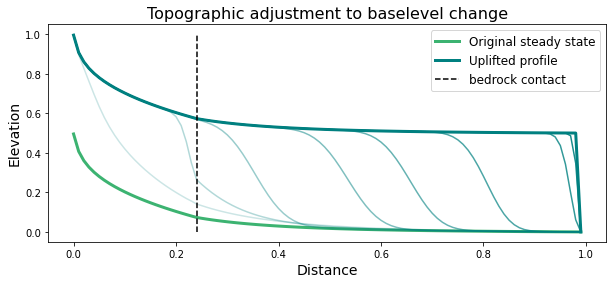

In [44]:
# cool, let's see how they plot
plt.figure(figsize = (10, 4))

plt.plot(x_2/100000, (eta_ss - adjustment_eta_ss)/400, label = 'Original steady state', color = 'mediumseagreen', linewidth = 3)
plt.plot(x_2/100000, (uplift_eta - adjustment_uplift_eta)/400, label = 'Uplifted profile', color = 'teal', linewidth = 3)
plt.plot(x_2/100000, (eta_uplift_1 - adjustment_eta_uplift_1)/400, color = 'teal', alpha = 0.9)
plt.plot(x_2/100000, (eta_uplift_10 - adjustment_eta_uplift_10)/400, color = 'teal', alpha = 0.8)
plt.plot(x_2/100000, (eta_uplift_100 - adjustment_eta_uplift_100)/400, color = 'teal', alpha = 0.7)
plt.plot(x_2/100000, (eta_uplift_200 - adjustment_eta_uplift_200)/400, color = 'teal', alpha = 0.6)
plt.plot(x_2/100000, (eta_uplift_300 - adjustment_eta_uplift_300)/400, color = 'teal', alpha = 0.5)
plt.plot(x_2/100000, (eta_uplift_500 - adjustment_eta_uplift_500)/400, color = 'teal', alpha = 0.4)
plt.plot(x_2/100000, (eta_uplift_1000 - adjustment_eta_uplift_1000)/400, color = 'teal', alpha = 0.3)
plt.plot(x_2/100000, (eta_uplift_10000 - adjustment_eta_uplift_10000)/400, color = 'teal', alpha = 0.2)
plt.vlines(x = 0.24, 
           ymin = 0, 
           ymax = 1, 
           label = 'bedrock contact', 
           color = 'k', 
           linestyle = '--')
plt.xlabel('Distance', fontsize = 14)
plt.ylabel('Elevation', fontsize = 14)
plt.title('Topographic adjustment to baselevel change', fontsize = 16)
plt.legend(fontsize = 12)

plt.savefig('csdms2022_knicks.png')
plt.show()